In [1]:
import torch
import supervision as sv
import rfdetr
from rfdetr import RFDETRMedium, RFDETRNano
from PIL import Image

In [2]:
checkpoint_path = "/Users/abdul/Downloads/finaloutput/checkpoint_best_ema.pth"

In [4]:
with open("/Users/abdul/Downloads/finaloutput/log.txt") as f:
    for i in range(10):
        print(f.readline().strip())




{"train_lr": 4.999999999999562e-05, "train_class_error": 24.93494578657261, "train_loss": 7.778406591294154, "train_loss_ce": 0.8363286618363667, "train_loss_bbox": 0.17686794242049908, "train_loss_giou": 0.48512747060278955, "train_loss_ce_0": 0.9056957510828708, "train_loss_bbox_0": 0.18322599297693137, "train_loss_giou_0": 0.49196550910628306, "train_loss_ce_1": 0.85784681700273, "train_loss_bbox_1": 0.17936825166281875, "train_loss_giou_1": 0.4890321652899713, "train_loss_ce_2": 0.8425701890612354, "train_loss_bbox_2": 0.17773949538551645, "train_loss_giou_2": 0.48653916275152403, "train_loss_ce_enc": 0.9053875994907189, "train_loss_bbox_enc": 0.22332676761434092, "train_loss_giou_enc": 0.5373848066714141, "train_loss_ce_unscaled": 0.8363286618363667, "train_class_error_unscaled": 24.93494578657261, "train_loss_bbox_unscaled": 0.03537358848688632, "train_loss_giou_unscaled": 0.24256373530139477, "train_cardinality_error_unscaled": 3883.7762576008845, "train_loss_ce_0_unscaled": 0.9

finetune rfdetr medium on subsets extract from the entire rf100

✅ Found 10 evaluation entries

📊 Final EMA Evaluation:
mAP@50–95: 0.5121
mAP@50: 0.7506
Precision: 0.6901
Recall: 0.7500


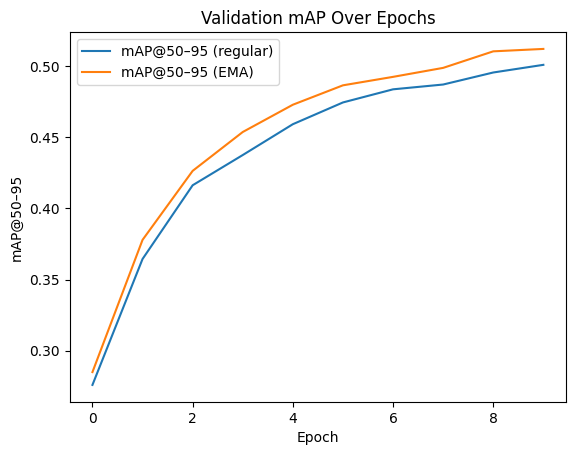

In [2]:
import json
import matplotlib.pyplot as plt

log_path = "/Users/abdul/Downloads/finaloutput/log.txt"

results = []

with open(log_path) as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            # check for either normal or ema metrics
            if "test_results_json" in data or "ema_test_results_json" in data:
                results.append(data)
        except:
            continue

print(f"✅ Found {len(results)} evaluation entries")

if not results:
    raise ValueError("No evaluation results found in log file")

# --- Compute mAP, Precision, Recall across epochs ---
epochs = list(range(len(results)))
map_regular, map_ema = [], []
map50_regular, map50_ema = [], []

for r in results:
    if "test_results_json" in r:
        cm = r["test_results_json"]["class_map"]
        map_regular.append(sum(c["map@50:95"] for c in cm) / len(cm))
        map50_regular.append(sum(c["map@50"] for c in cm) / len(cm))
    if "ema_test_results_json" in r:
        cm = r["ema_test_results_json"]["class_map"]
        map_ema.append(sum(c["map@50:95"] for c in cm) / len(cm))
        map50_ema.append(sum(c["map@50"] for c in cm) / len(cm))

# --- Print latest epoch summary ---
latest = results[-1]
ema = latest.get("ema_test_results_json", {}).get("class_map", [])
if ema:
    mean_map_50_95 = sum(c["map@50:95"] for c in ema) / len(ema)
    mean_map_50 = sum(c["map@50"] for c in ema) / len(ema)
    mean_precision = sum(c["precision"] for c in ema) / len(ema)
    mean_recall = sum(c["recall"] for c in ema) / len(ema)
    print("\n📊 Final EMA Evaluation:")
    print(f"mAP@50–95: {mean_map_50_95:.4f}")
    print(f"mAP@50: {mean_map_50:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")

# --- Plot mAP curves ---
plt.plot(epochs, map_regular, label="mAP@50–95 (regular)")
plt.plot(epochs, map_ema, label="mAP@50–95 (EMA)")
plt.xlabel("Epoch")
plt.ylabel("mAP@50–95")
plt.title("Validation mAP Over Epochs")
plt.legend()
plt.show()


✅ Found 10 evaluation entries
📅 Detected eval_every ≈ 1 epochs

📊 Final EMA Evaluation:
mAP@50–95: 0.5121
mAP@50: 0.7506
Precision: 0.6901
Recall: 0.7500


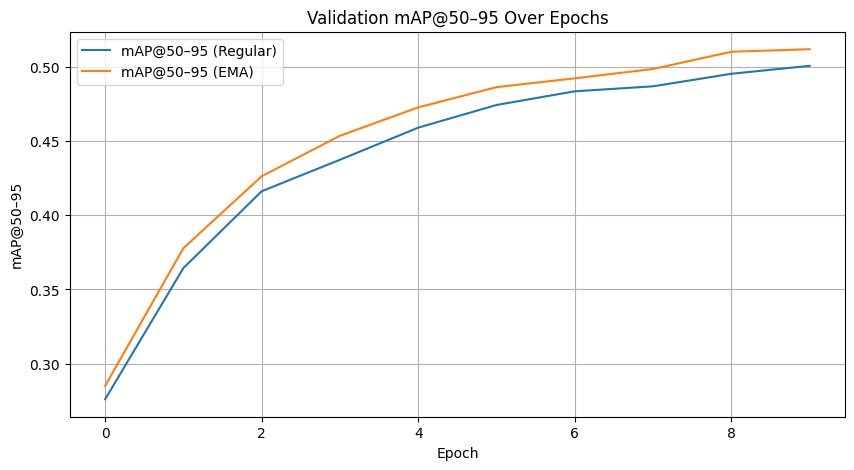

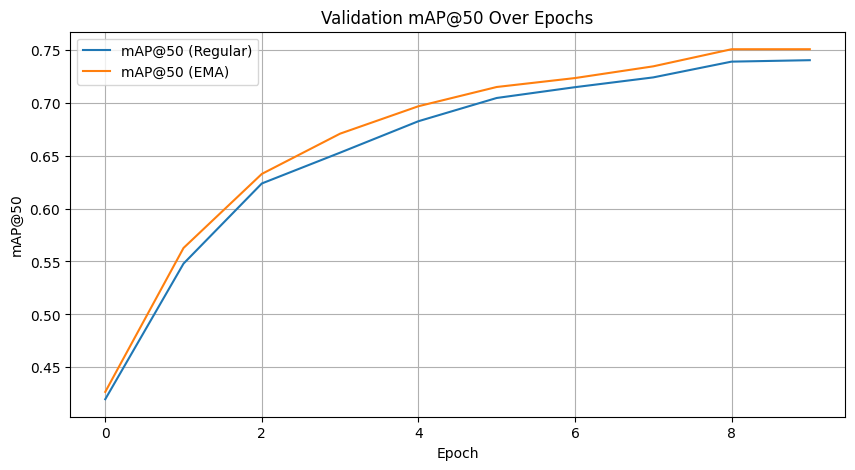

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 🔧 path to your training log
log_path = "/Users/abdul/Downloads/finaloutput/log.txt"

results = []
with open(log_path) as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if "test_results_json" in data or "ema_test_results_json" in data:
                results.append(data)
        except:
            continue

print(f"✅ Found {len(results)} evaluation entries")

if not results:
    raise ValueError("No evaluation results found in log file")

# --- Detect eval interval if available ---
# we’ll assume roughly one evaluation per eval_every epochs
# infer by looking at last reported epoch value (if present)
epochs_logged = []
for r in results:
    if "epoch" in r:
        epochs_logged.append(r["epoch"])
eval_every = 1
if len(epochs_logged) > 1:
    diffs = np.diff(sorted(set(epochs_logged)))
    eval_every = int(np.median(diffs)) if len(diffs) else 1
print(f"📅 Detected eval_every ≈ {eval_every} epochs")

# --- Extract metrics ---
epochs = [i * eval_every for i in range(len(results))]
map95_regular, map95_ema = [], []
map50_regular, map50_ema = [], []

for r in results:
    if "test_results_json" in r:
        cm = r["test_results_json"]["class_map"]
        map95_regular.append(np.mean([c["map@50:95"] for c in cm]))
        map50_regular.append(np.mean([c["map@50"] for c in cm]))
    if "ema_test_results_json" in r:
        cm = r["ema_test_results_json"]["class_map"]
        map95_ema.append(np.mean([c["map@50:95"] for c in cm]))
        map50_ema.append(np.mean([c["map@50"] for c in cm]))

# --- Final EMA summary ---
ema = results[-1].get("ema_test_results_json", {}).get("class_map", [])
if ema:
    mean_map_50_95 = np.mean([c["map@50:95"] for c in ema])
    mean_map_50 = np.mean([c["map@50"] for c in ema])
    mean_precision = np.mean([c["precision"] for c in ema])
    mean_recall = np.mean([c["recall"] for c in ema])
    print("\n📊 Final EMA Evaluation:")
    print(f"mAP@50–95: {mean_map_50_95:.4f}")
    print(f"mAP@50: {mean_map_50:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")

# --- Plot 1: mAP@50–95 ---
plt.figure(figsize=(10,5))
plt.plot(epochs, map95_regular, label="mAP@50–95 (Regular)")
plt.plot(epochs, map95_ema, label="mAP@50–95 (EMA)")
plt.xlabel("Epoch")
plt.ylabel("mAP@50–95")
plt.title("Validation mAP@50–95 Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: mAP@50 ---
plt.figure(figsize=(10,5))
plt.plot(epochs, map50_regular, label="mAP@50 (Regular)")
plt.plot(epochs, map50_ema, label="mAP@50 (EMA)")
plt.xlabel("Epoch")
plt.ylabel("mAP@50")
plt.title("Validation mAP@50 Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


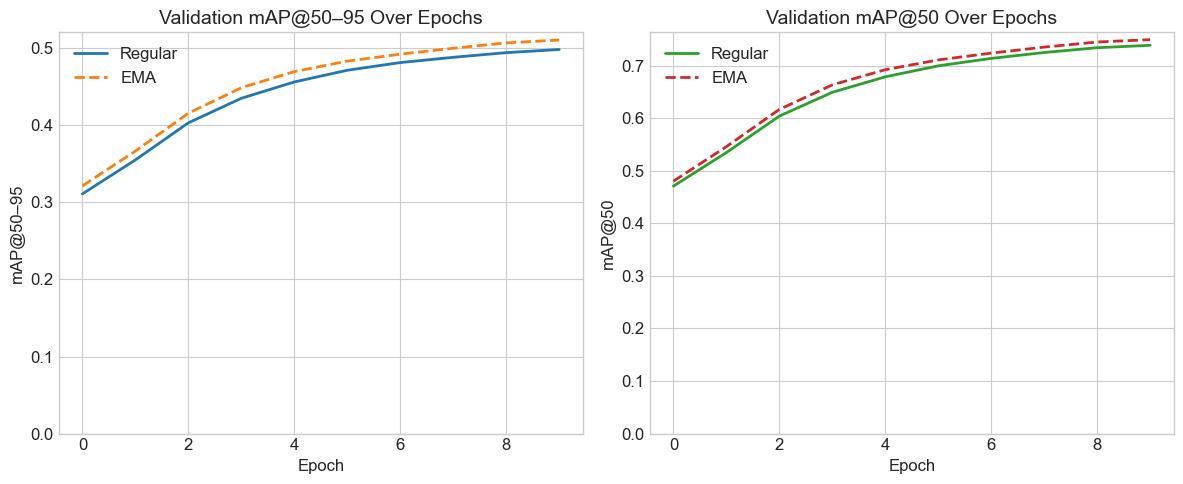

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

log_path = "/Users/abdul/Downloads/finaloutput/log.txt"
results = []

# Parse logs
with open(log_path) as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if "test_results_json" in data or "ema_test_results_json" in data:
                results.append(data)
        except:
            continue

epochs = list(range(len(results)))
map_regular, map_ema = [], []
map50_regular, map50_ema = [], []

for r in results:
    if "test_results_json" in r:
        cm = r["test_results_json"]["class_map"]
        map_regular.append(sum(c["map@50:95"] for c in cm) / len(cm))
        map50_regular.append(sum(c["map@50"] for c in cm) / len(cm))
    if "ema_test_results_json" in r:
        cm = r["ema_test_results_json"]["class_map"]
        map_ema.append(sum(c["map@50:95"] for c in cm) / len(cm))
        map50_ema.append(sum(c["map@50"] for c in cm) / len(cm))

# --- Smooth curves for presentation ---
map_regular_s = gaussian_filter1d(map_regular, sigma=1)
map_ema_s = gaussian_filter1d(map_ema, sigma=1)
map50_regular_s = gaussian_filter1d(map50_regular, sigma=1)
map50_ema_s = gaussian_filter1d(map50_ema, sigma=1)

# --- Plot settings ---
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"font.size": 12, "axes.titlesize": 14, "axes.labelsize": 12})

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot mAP@50-95
ax[0].plot(epochs, map_regular_s, label="Regular", color="#1f77b4", linewidth=2)
ax[0].plot(epochs, map_ema_s, label="EMA", color="#ff7f0e", linewidth=2, linestyle="--")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("mAP@50–95")
ax[0].set_title("Validation mAP@50–95 Over Epochs")
ax[0].legend()
ax[0].set_ylim(bottom=0)

# Plot mAP@50
ax[1].plot(epochs, map50_regular_s, label="Regular", color="#2ca02c", linewidth=2)
ax[1].plot(epochs, map50_ema_s, label="EMA", color="#d62728", linewidth=2, linestyle="--")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("mAP@50")
ax[1].set_title("Validation mAP@50 Over Epochs")
ax[1].legend()
ax[1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()


top classes based on map@50 and map@50:95

In [5]:
import json
import pandas as pd
log_path = "/Users/abdul/Downloads/finaloutput/log.txt"
with open(log_path) as f:
    for line in f:
        if "ema_test_results_json" in line:
            data = json.loads(line)
final_map = data["ema_test_results_json"]["class_map"]
df = pd.DataFrame(final_map)
df.sort_values("map@50:95", ascending=False).head(10)


,class,map@50:95,map@50,precision,recall
374,Light Front,0.983480,1.000000,1.000000,0.75
260,No Defect,0.980032,0.980032,0.976190,0.75
213,trash,0.977613,1.000000,1.000000,0.75
398,IC Bottom,0.976623,1.000000,1.000000,0.75
360,reference text,0.963255,0.981139,0.994318,0.75
208,Pastinaak,0.959562,0.975524,0.996904,0.75
17,subwoofer_blue,0.946223,1.000000,1.000000,0.75
533,Wheel,0.941917,0.999681,1.000000,0.75
161,Normal Panel,0.915551,0.991718,1.000000,0.75
401,LED Bottom,0.912832,0.952448,1.000000,0.75


In [5]:
import json

log_path = "/Users/abdul/Downloads/rf100vl_outputs_re/log.txt"

keys_seen = set()
count = 0

with open(log_path) as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            keys_seen.update(data.keys())
            count += 1
            if count >= 20:
                break
        except:
            pass

print("📌 Keys found in log:", keys_seen)


📌 Keys found in log: {'test_loss_bbox_unscaled', 'ema_test_loss_giou_enc', 'ema_test_loss_bbox_enc_unscaled', 'train_class_error_unscaled', 'test_cardinality_error_2_unscaled', 'test_loss_ce_1_unscaled', 'train_loss_bbox_0_unscaled', 'ema_test_loss_bbox_1_unscaled', 'test_loss_giou_enc', 'ema_test_class_error_unscaled', 'train_loss_bbox_enc', 'train_loss_bbox', 'ema_test_loss_ce_enc', 'ema_test_loss_bbox_0', 'train_loss_ce_0_unscaled', 'ema_test_cardinality_error_2_unscaled', 'test_loss_giou', 'test_loss_ce_2', 'ema_test_cardinality_error_enc_unscaled', 'test_loss_ce_0_unscaled', 'ema_best_res', 'test_loss_bbox_enc', 'ema_test_loss_giou_1', 'train_loss_ce_1', 'train_loss_giou_enc', 'test_loss_giou_0', 'ema_test_loss_ce_1', 'train_loss_bbox_0', 'test_loss_giou_1', 'ema_best_ep', 'ema_test_loss_ce_unscaled', 'ema_test_loss_ce_0_unscaled', 'test_loss_bbox', 'ema_test_loss_ce_enc_unscaled', 'train_cardinality_error_enc_unscaled', 'train_loss_ce_enc', 'ema_test_loss_bbox_2_unscaled', 'train

📊 Loaded 10 training-loss steps


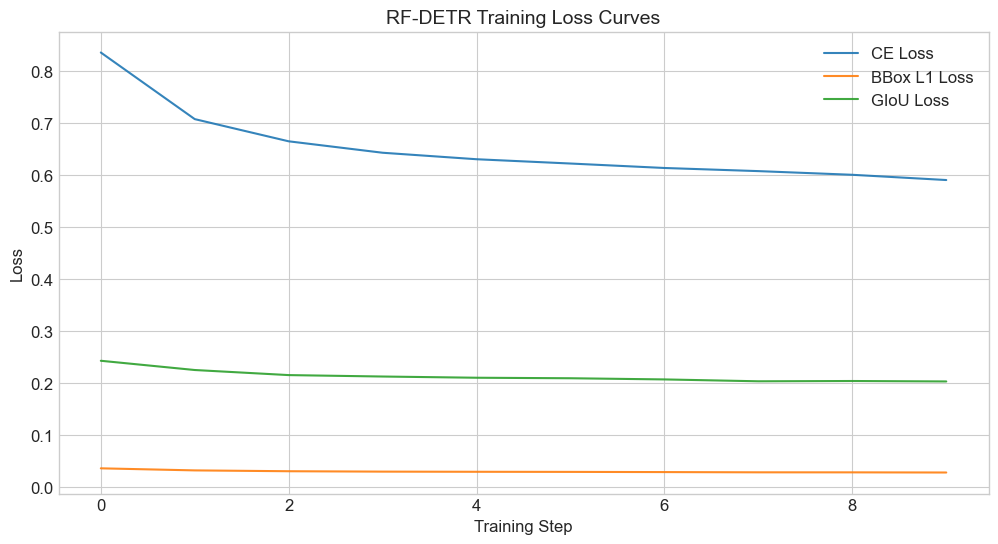

In [6]:
import json
import matplotlib.pyplot as plt

log_path = "/Users/abdul/Downloads/finaloutput/log.txt"

steps = []
loss_ce = []
loss_bbox = []
loss_giou = []

with open(log_path) as f:
    step = 0
    for line in f:
        try:
            data = json.loads(line.strip())

            # Collect losses only if present
            ce = data.get("train_loss_ce")
            bbox = data.get("train_loss_bbox_unscaled")
            giou = data.get("train_loss_giou_unscaled")

            # Append only if at least one loss exists
            if ce is not None or bbox is not None or giou is not None:
                steps.append(step)
                loss_ce.append(ce)
                loss_bbox.append(bbox)
                loss_giou.append(giou)
                step += 1

        except:
            continue

print(f"📊 Loaded {len(steps)} training-loss steps")

# ---- PLOT ----
plt.figure(figsize=(12,6))
plt.plot(steps, loss_ce, label="CE Loss", alpha=0.9)
plt.plot(steps, loss_bbox, label="BBox L1 Loss", alpha=0.9)
plt.plot(steps, loss_giou, label="GIoU Loss", alpha=0.9)

plt.title("RF-DETR Training Loss Curves")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


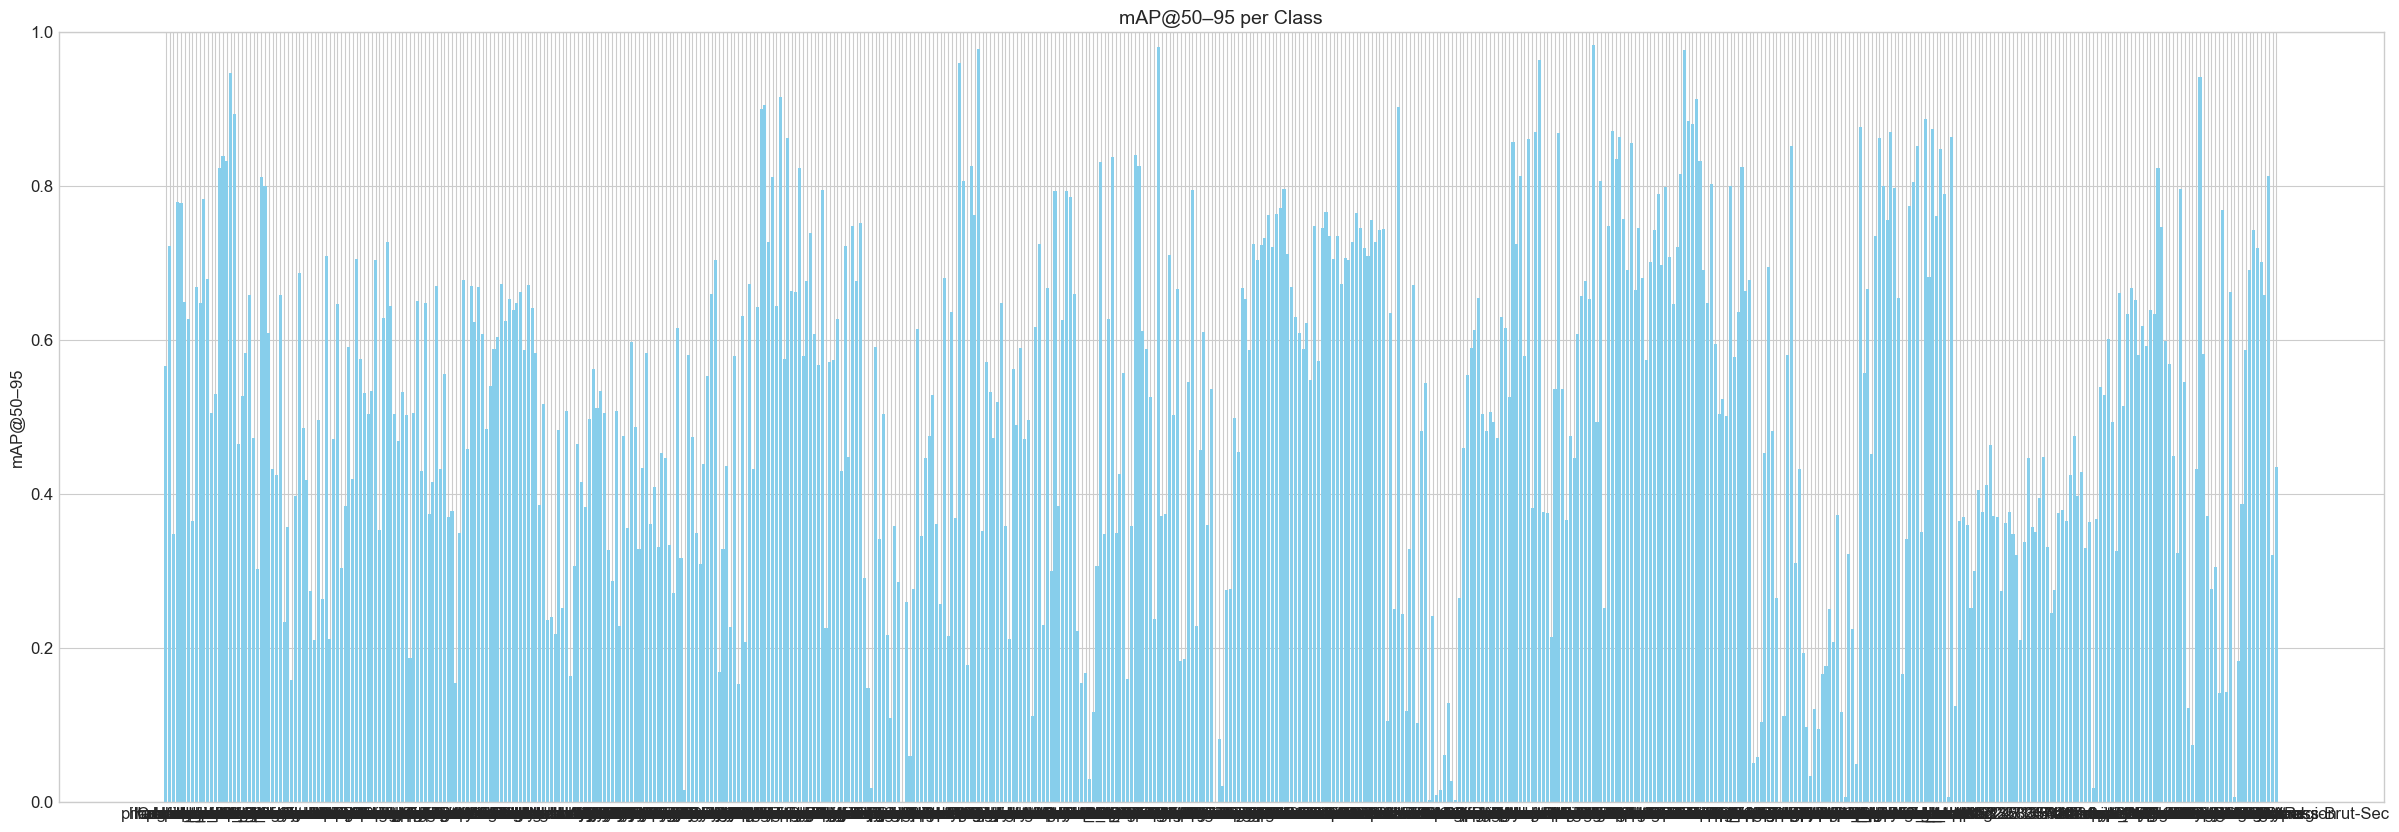

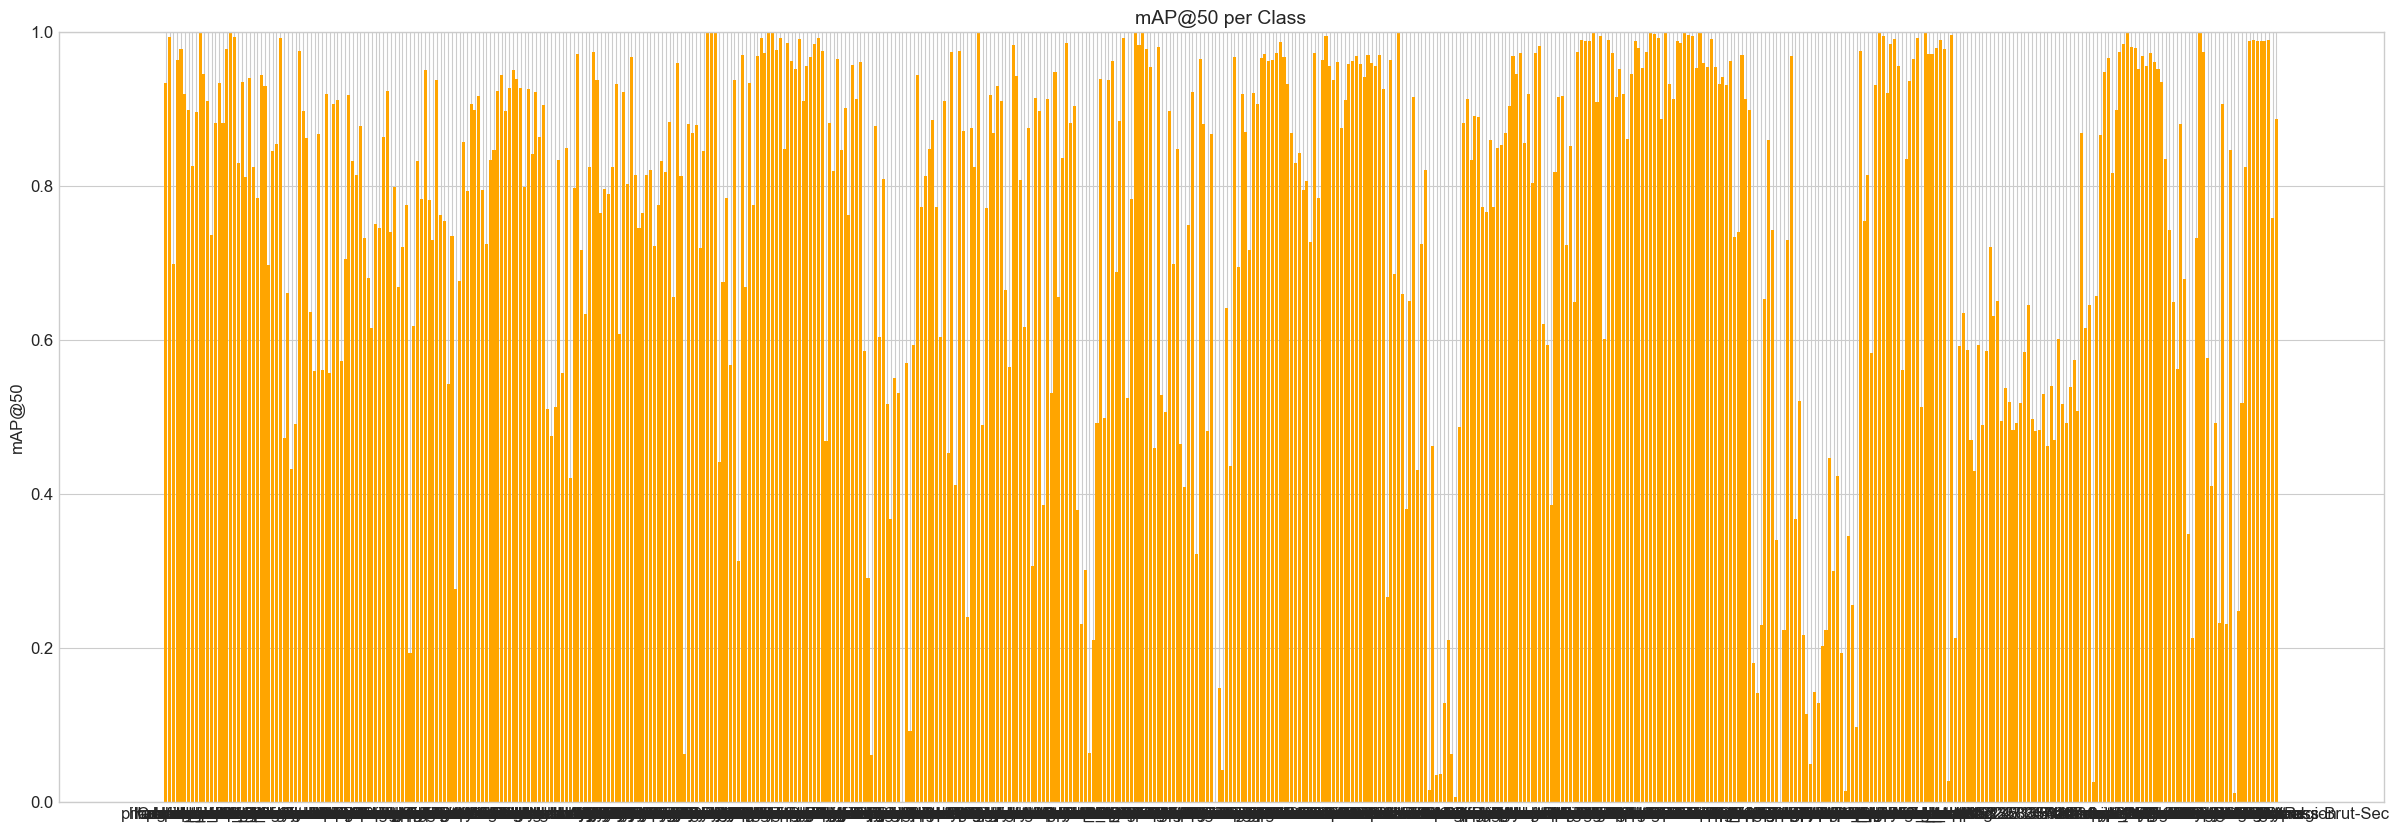

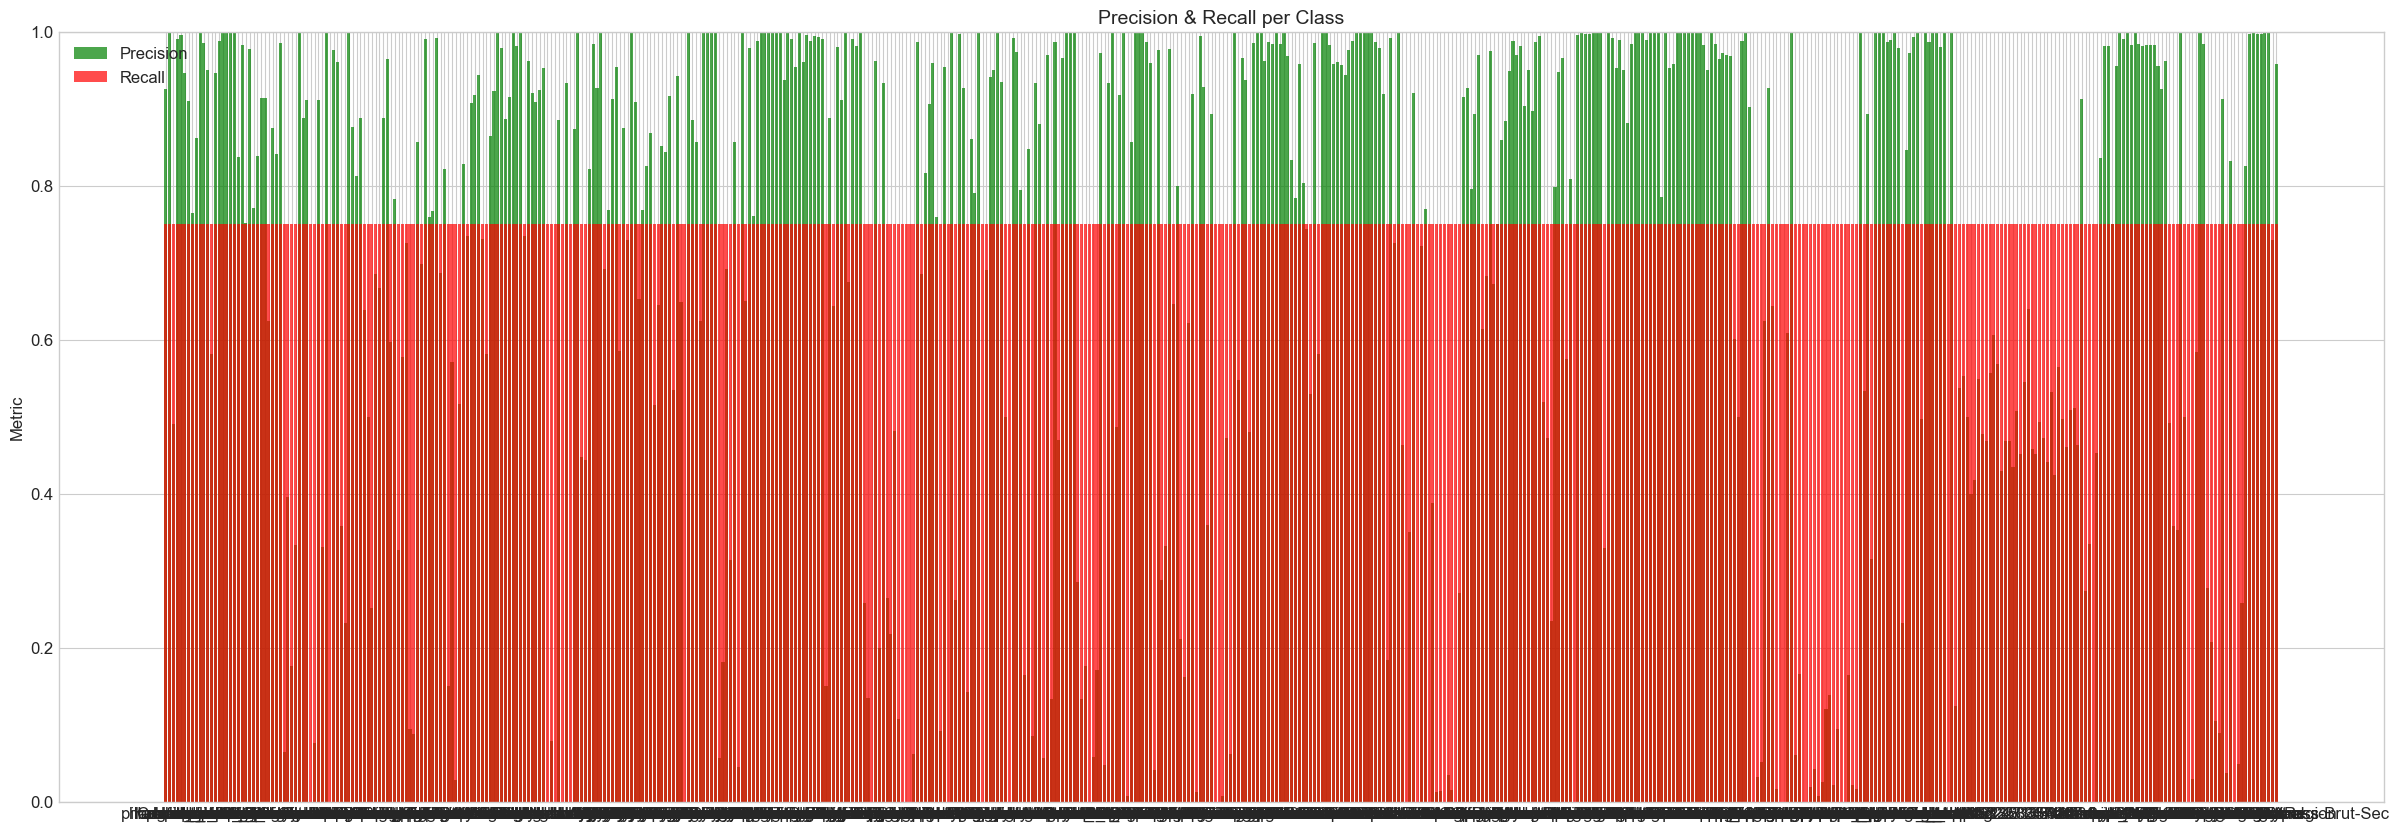

---- SUMMARY ----
Mean mAP@50–95: 0.5666
Mean mAP@50:    0.7506
Precision:      0.6901
Recall:         0.7500


In [7]:
import json
import matplotlib.pyplot as plt

PATH = "/Users/abdul/Downloads/finaloutput/results.json"   # change this

with open(PATH, "r") as f:
    data = json.load(f)

# Extract metrics
entries = data["class_map"]["valid"]

# Filter out the aggregated "all"
entries = [e for e in entries if e["class"] != "all"]

classes = [e["class"] for e in entries]
map_50_95 = [e["map@50:95"] for e in entries]
map_50 = [e["map@50"] for e in entries]
precision = [e["precision"] for e in entries]
recall = [e["recall"] for e in entries]

# ------- Plot mAP@50-95 -------
plt.figure(figsize=(30,10))
plt.bar(classes, map_50_95, color="skyblue")
plt.title("mAP@50–95 per Class")
plt.ylabel("mAP@50–95")
plt.ylim(0,1)
plt.show()

# ------- Plot mAP@50 -------
plt.figure(figsize=(30,10))
plt.bar(classes, map_50, color="orange")
plt.title("mAP@50 per Class")
plt.ylabel("mAP@50")
plt.ylim(0,1)
plt.show()

# ------- Plot Precision & Recall -------
plt.figure(figsize=(30,10))
plt.bar(classes, precision, color="green", alpha=0.7, label="Precision")
plt.bar(classes, recall, color="red", alpha=0.7, label="Recall")
plt.title("Precision & Recall per Class")
plt.ylabel("Metric")
plt.ylim(0,1)
plt.legend()
plt.show()

# ------- Print summary -------
print("---- SUMMARY ----")
print(f"Mean mAP@50–95: {data['class_map']['valid'][0]['map@50:95']:.4f}")
print(f"Mean mAP@50:    {data['map']:.4f}")
print(f"Precision:      {data['precision']:.4f}")
print(f"Recall:         {data['recall']:.4f}")

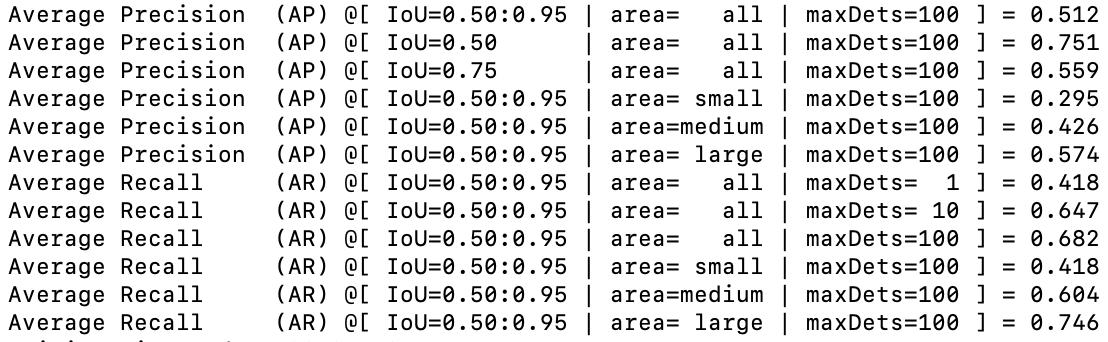

finetuning rfdetr medium on single dataset-rf100 aerial cow

✅ Found 50 evaluation entries

📊 Final EMA Evaluation:
mAP@50–95: 0.4431
mAP@50: 0.8364
Precision: 0.9134
Recall: 0.7700


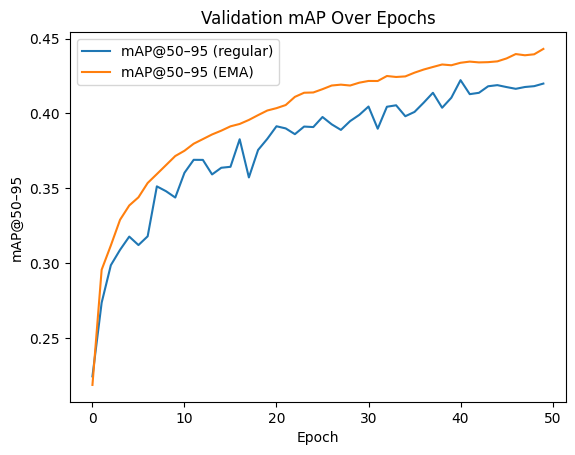

In [1]:
import json
import matplotlib.pyplot as plt

log_path = "/Users/abdul/Downloads/aerial-cow/log.txt"

results = []

with open(log_path) as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            # check for either normal or ema metrics
            if "test_results_json" in data or "ema_test_results_json" in data:
                results.append(data)
        except:
            continue

print(f"✅ Found {len(results)} evaluation entries")

if not results:
    raise ValueError("No evaluation results found in log file")

# --- Compute mAP, Precision, Recall across epochs ---
epochs = list(range(len(results)))
map_regular, map_ema = [], []
map50_regular, map50_ema = [], []

for r in results:
    if "test_results_json" in r:
        cm = r["test_results_json"]["class_map"]
        map_regular.append(sum(c["map@50:95"] for c in cm) / len(cm))
        map50_regular.append(sum(c["map@50"] for c in cm) / len(cm))
    if "ema_test_results_json" in r:
        cm = r["ema_test_results_json"]["class_map"]
        map_ema.append(sum(c["map@50:95"] for c in cm) / len(cm))
        map50_ema.append(sum(c["map@50"] for c in cm) / len(cm))

# --- Print latest epoch summary ---
latest = results[-1]
ema = latest.get("ema_test_results_json", {}).get("class_map", [])
if ema:
    mean_map_50_95 = sum(c["map@50:95"] for c in ema) / len(ema)
    mean_map_50 = sum(c["map@50"] for c in ema) / len(ema)
    mean_precision = sum(c["precision"] for c in ema) / len(ema)
    mean_recall = sum(c["recall"] for c in ema) / len(ema)
    print("\n📊 Final EMA Evaluation:")
    print(f"mAP@50–95: {mean_map_50_95:.4f}")
    print(f"mAP@50: {mean_map_50:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")

# --- Plot mAP curves ---
plt.plot(epochs, map_regular, label="mAP@50–95 (regular)")
plt.plot(epochs, map_ema, label="mAP@50–95 (EMA)")
plt.xlabel("Epoch")
plt.ylabel("mAP@50–95")
plt.title("Validation mAP Over Epochs")
plt.legend()
plt.show()


✅ Found 50 evaluation entries
📅 Detected eval_every ≈ 1 epochs

📊 Final EMA Evaluation:
mAP@50–95: 0.4431
mAP@50: 0.8364
Precision: 0.9134
Recall: 0.7700


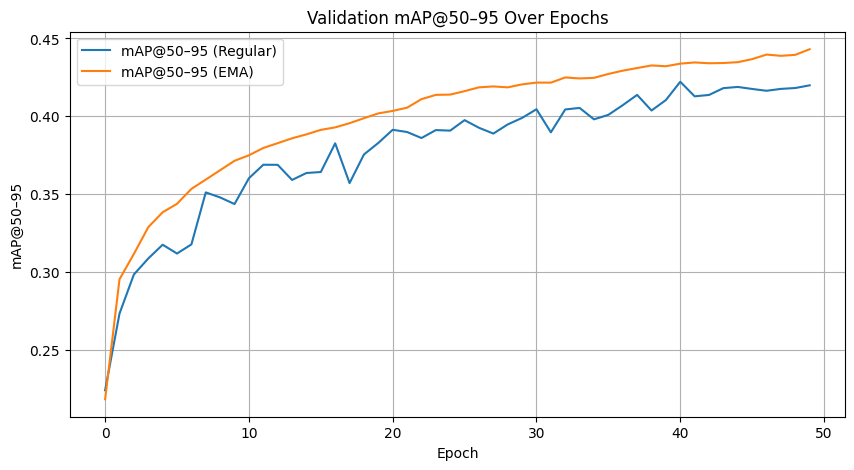

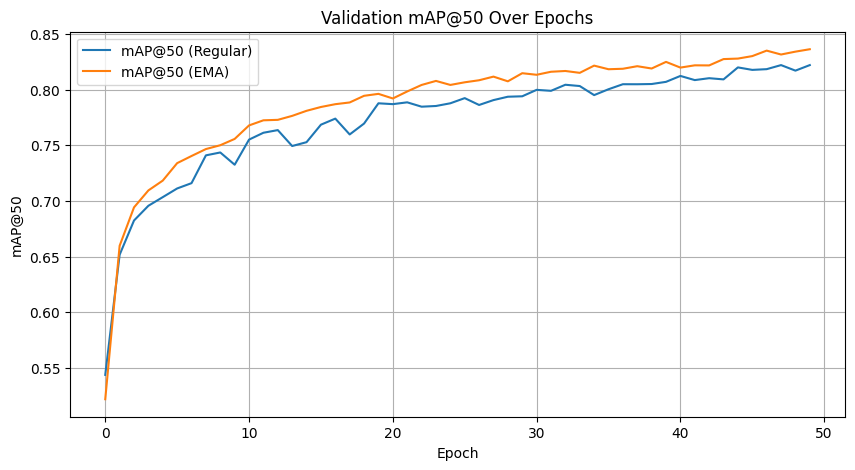

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 🔧 path to your training log
log_path = "/Users/abdul/Downloads/aerial-cow/log.txt"

results = []
with open(log_path) as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if "test_results_json" in data or "ema_test_results_json" in data:
                results.append(data)
        except:
            continue

print(f"✅ Found {len(results)} evaluation entries")

if not results:
    raise ValueError("No evaluation results found in log file")

# --- Detect eval interval if available ---
# we’ll assume roughly one evaluation per eval_every epochs
# infer by looking at last reported epoch value (if present)
epochs_logged = []
for r in results:
    if "epoch" in r:
        epochs_logged.append(r["epoch"])
eval_every = 1
if len(epochs_logged) > 1:
    diffs = np.diff(sorted(set(epochs_logged)))
    eval_every = int(np.median(diffs)) if len(diffs) else 1
print(f"📅 Detected eval_every ≈ {eval_every} epochs")

# --- Extract metrics ---
epochs = [i * eval_every for i in range(len(results))]
map95_regular, map95_ema = [], []
map50_regular, map50_ema = [], []

for r in results:
    if "test_results_json" in r:
        cm = r["test_results_json"]["class_map"]
        map95_regular.append(np.mean([c["map@50:95"] for c in cm]))
        map50_regular.append(np.mean([c["map@50"] for c in cm]))
    if "ema_test_results_json" in r:
        cm = r["ema_test_results_json"]["class_map"]
        map95_ema.append(np.mean([c["map@50:95"] for c in cm]))
        map50_ema.append(np.mean([c["map@50"] for c in cm]))

# --- Final EMA summary ---
ema = results[-1].get("ema_test_results_json", {}).get("class_map", [])
if ema:
    mean_map_50_95 = np.mean([c["map@50:95"] for c in ema])
    mean_map_50 = np.mean([c["map@50"] for c in ema])
    mean_precision = np.mean([c["precision"] for c in ema])
    mean_recall = np.mean([c["recall"] for c in ema])
    print("\n📊 Final EMA Evaluation:")
    print(f"mAP@50–95: {mean_map_50_95:.4f}")
    print(f"mAP@50: {mean_map_50:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")

# --- Plot 1: mAP@50–95 ---
plt.figure(figsize=(10,5))
plt.plot(epochs, map95_regular, label="mAP@50–95 (Regular)")
plt.plot(epochs, map95_ema, label="mAP@50–95 (EMA)")
plt.xlabel("Epoch")
plt.ylabel("mAP@50–95")
plt.title("Validation mAP@50–95 Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: mAP@50 ---
plt.figure(figsize=(10,5))
plt.plot(epochs, map50_regular, label="mAP@50 (Regular)")
plt.plot(epochs, map50_ema, label="mAP@50 (EMA)")
plt.xlabel("Epoch")
plt.ylabel("mAP@50")
plt.title("Validation mAP@50 Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

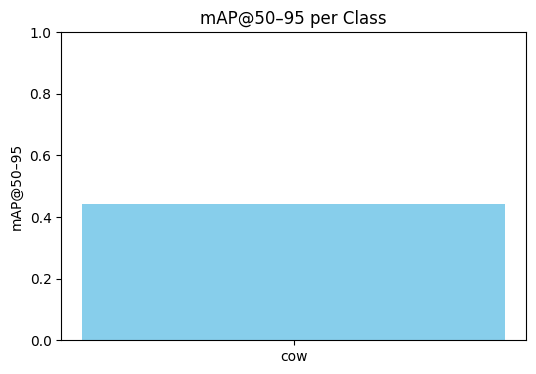

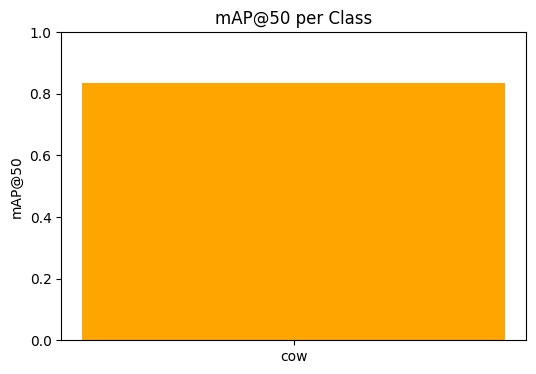

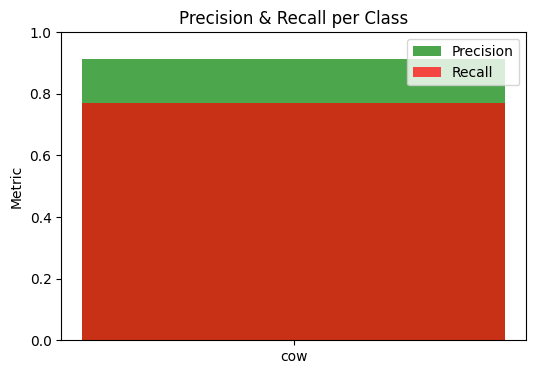

---- SUMMARY ----
Mean mAP@50–95: 0.4431
Mean mAP@50:    0.8364
Precision:      0.9134
Recall:         0.7700


In [7]:
import json
import matplotlib.pyplot as plt

PATH = "/Users/abdul/Downloads/aerial-cow/results.json"   # change this

with open(PATH, "r") as f:
    data = json.load(f)

# Extract metrics
entries = data["class_map"]["valid"]

# Filter out the aggregated "all"
entries = [e for e in entries if e["class"] != "all"]

classes = [e["class"] for e in entries]
map_50_95 = [e["map@50:95"] for e in entries]
map_50 = [e["map@50"] for e in entries]
precision = [e["precision"] for e in entries]
recall = [e["recall"] for e in entries]

# ------- Plot mAP@50-95 -------
plt.figure(figsize=(6,4))
plt.bar(classes, map_50_95, color="skyblue")
plt.title("mAP@50–95 per Class")
plt.ylabel("mAP@50–95")
plt.ylim(0,1)
plt.show()

# ------- Plot mAP@50 -------
plt.figure(figsize=(6,4))
plt.bar(classes, map_50, color="orange")
plt.title("mAP@50 per Class")
plt.ylabel("mAP@50")
plt.ylim(0,1)
plt.show()

# ------- Plot Precision & Recall -------
plt.figure(figsize=(6,4))
plt.bar(classes, precision, color="green", alpha=0.7, label="Precision")
plt.bar(classes, recall, color="red", alpha=0.7, label="Recall")
plt.title("Precision & Recall per Class")
plt.ylabel("Metric")
plt.ylim(0,1)
plt.legend()
plt.show()

# ------- Print summary -------
print("---- SUMMARY ----")
print(f"Mean mAP@50–95: {data['class_map']['valid'][0]['map@50:95']:.4f}")
print(f"Mean mAP@50:    {data['map']:.4f}")
print(f"Precision:      {data['precision']:.4f}")
print(f"Recall:         {data['recall']:.4f}")
